In [1]:
from visualizer import get_local
get_local.activate()

import os
ROOT_PATH="/data/aofei"
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
os.environ["TRANSFORMERS_CACHE"] = f"{ROOT_PATH}/huggingface_cache/transformers"
os.environ["HF_HOME"] = f"{ROOT_PATH}/huggingface_cache/transformers"

import torch
import torch.nn.functional as F
import json
import copy
import numpy as np

import math
from PIL import Image, ImageDraw
import torch
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
# from utils import compute_ca_loss, show_image_relevance
from torchviz import make_dot
import clip
import torchvision.transforms as transforms
import numpy as np
import math
import cv2

/data/aofei/conda/env/control_llm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/avc6555/research/MedH/visualize/toolkits/transformers/src/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )
model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", quantization_config=quantization_config, device_map="auto")
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
device = "cuda" if torch.cuda.is_available() else "cpu"

/data/aofei/conda/env/control_llm/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/avc6555/research/MedH/visualize/toolkits/transformers/src/transformers/models/llava/configuration_llava.py:103: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 3/3 [01:22<00:00, 27.62s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
import clip
_, preprocess = clip.load("ViT-B/32", device='cpu', jit=False)

In [21]:

def get_attention_weights_example(question, image_path, conv_mode="simple"):
    image = Image.open(image_path)
    iw, ih = image.size
    prompt = "USER: <image>\n{}ASSISTANT:".format(question)
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    # print(inputs['input_ids'])
    img_token_idx = int(torch.where(inputs['input_ids'] == 32000)[1])

     # Generate input embeds
    inputs_embeds = model.get_input_embeddings()(inputs.input_ids)

    if inputs.pixel_values is not None and inputs.input_ids.shape[1] != 1:
        image_outputs = model.vision_tower(inputs.pixel_values, output_hidden_states=True)
        # this is not memory efficient at all (output_hidden_states=True) will save all the hidden stated.
        selected_image_feature = image_outputs.hidden_states[model.config.vision_feature_layer]
        
        vision_feature_select_strategy = model.config.vision_feature_select_strategy
        if vision_feature_select_strategy == "default":
            selected_image_feature = selected_image_feature[:, 1:]
        elif vision_feature_select_strategy == "full":
            selected_image_feature = selected_image_feature
        else:
            raise ValueError(
                f"Unexpected select feature strategy: {model.config.vision_feature_select_strategy}"
            )

        image_features = model.multi_modal_projector(selected_image_feature)
        inputs_embeds, attention_mask, labels, position_ids = model._merge_input_ids_with_image_features(
            image_features, inputs_embeds, inputs.input_ids, inputs.attention_mask, labels=None
        )
        if labels is None:
            labels = torch.full_like(attention_mask, model.config.ignore_index).to(torch.long)

        get_local.clear()
        torch.cuda.empty_cache()
    # print(inputs_embeds.size())
    with torch.no_grad():
        outputs = model.generate(inputs_embeds=inputs_embeds, attention_mask=attention_mask, max_new_tokens=64, return_dict_in_generate=True, output_scores=True)
        cache = get_local.cache
        generate_ids = outputs.sequences
        logits = outputs.scores
        output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    return cache, output, img_token_idx


In [13]:
image_path = "./images/Getty_cat.jpg"
question = "What is unusual of the upper cat?"
cache, output, outputs = get_attention_weights_example(question=question, image_path=image_path)

tensor([[    1,  3148,  1001, 29901, 29871, 32000, 29871,    13,  5618,   338,
         22910,   310,   278,  7568,  6635, 29973, 22933,  9047, 13566, 29901]],
       device='cuda:0')
torch.Size([1, 595, 4096])


In [17]:
cache['LlamaSdpaAttention.forward'][32*(1+1):32*(1+2)][0].size()

torch.Size([1, 32, 1, 597])

In [30]:
image_path = "./images/Getty_cat.jpg"
question = "What is unusual of the upper cat?"
cache, text, img_token_idx = get_attention_weights_example(question=question, image_path=image_path)
# cache, text, img_token_idx = get_attention_weights_example(model=model, question=question, image_path=image_path)
print(text)
for i in range(2, 3):
    attn_all_layers = cache['LlamaSdpaAttention.forward'][32*(i+1):32*(i+2)]
    token = processor.batch_decode(outputs["sequences"])[0][i]
    print(token, "token")
    print(attn_all_layers[0].size(), "attn layers")
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    image_attns = attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+576]
    image_attn_sum = torch.sum(image_attns)
    attn_before_image = attn_all_layers_tensor[:, :, 1:img_token_idx]
    attn_after_image = attn_all_layers_tensor[:, :, img_token_idx+576:]
    text_attn_sum = torch.sum(attn_before_image)
    text_attn_sum2 = torch.sum(attn_after_image)
    print(image_attns.size(), image_attn_sum, attn_before_image.size(), attn_after_image.size(),  text_attn_sum, text_attn_sum2)
    # fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)


The unusual aspect of the upper cat is that it is jumping in the air while holding another cat in its mouth. This is not a typical behavior for cats, as they usually do not engage in such actions. The scene is quite captivating and might be a result of the cat's playful
e token
torch.Size([1, 32, 1, 598]) attn layers
torch.Size([32, 1, 576]) tensor(2.6172, device='cuda:0', dtype=torch.float16) torch.Size([32, 1, 4]) torch.Size([32, 1, 17]) tensor(0.0513, device='cuda:0', dtype=torch.float16) tensor(6.9336, device='cuda:0', dtype=torch.float16)


In [7]:
2.8496 / (2.8496 + 19.0156 + 10.1406)

0.08903386261240152

In [33]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def pad_and_concat_attentions(attention_tuple, max_seq_len):
    """
    Pad attention maps with zeros and concatenate them.
    
    Args:
    - attention_tuple: Tuple of attention tensors, where each tensor corresponds to one generated token's attention.
                       Shape: (generated_token_length, layers, 1, heads, 1, seq_len)
    - max_seq_len: The maximum sequence length to pad to.
    
    Returns:
    - concatenated_attentions: Tensor of concatenated attention maps (generated_token_length, seq_len)
    """
    padded_attentions = []
    
    for attn_tensor in attention_tuple:
        # print(attn_tensor.size())
        seq_len = attn_tensor[0].shape[-1]  # Current sequence length for this token
        padding_len = max_seq_len - seq_len
        
        attn_tensor = torch.cat(attn_tensor, 0).mean(0)
        # print(attn_tensor.size())
        # Average over layers and heads
        attn_tensor_avg = attn_tensor.mean(0).squeeze().squeeze().cpu() # Shape: (seq_len,)
        
        # Pad attention tensor with zeros to match max_seq_len
        if padding_len > 0:
            attn_tensor_avg = torch.cat([attn_tensor_avg, torch.zeros(padding_len)], dim=-1)
        
        padded_attentions.append(attn_tensor_avg)
    
    # Concatenate attentions across generated tokens
    concatenated_attentions = torch.stack(padded_attentions, dim=0)
    
    return concatenated_attentions

def draw_concatenated_attention_heatmap(concatenated_attentions):
    """
    Draw a heatmap of concatenated attention scores.
    
    Args:
    - concatenated_attentions: Tensor of concatenated attention scores (generated_token_length, seq_len).
    """
    
    plt.figure(figsize=(12, 4))
    
    # Convert tensor to numpy for plotting
    attention_data = concatenated_attentions.cpu().detach().numpy()
    
    sns.heatmap(attention_data, cmap='coolwarm', cbar=True)
    
    plt.title("Concatenated Attention Heatmap (All Tokens)")
    plt.xlabel("Sequence Length (Tokens)")
    plt.ylabel("Generated Tokens")
    plt.tight_layout()
    plt.show()


In [41]:
a = torch.rand(2,3,4)
torch.mean(a)

tensor(0.4746)

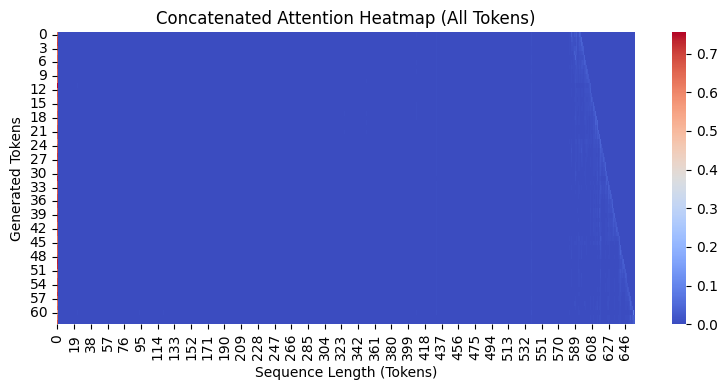

In [31]:
# Assume that the output attentions are of the shape (generated_token_length, layers, 1, heads, 1, seq_len)
generated_token_length = int(len(cache['LlamaSdpaAttention.forward']) / 32 - 1)

max_seq_len = cache['LlamaSdpaAttention.forward'][-1].shape[-1] # Max sequence length over all generated tokens

# Pad and concatenate attentions
attns_per_token = []
for i in range(generated_token_length):
    attns_per_token.append(cache['LlamaSdpaAttention.forward'][32*(i+1):32*(i+2)])
concatenated_attentions = pad_and_concat_attentions(attns_per_token, max_seq_len)

# Draw heatmap
draw_concatenated_attention_heatmap(concatenated_attentions)

In [25]:
len(cache['LlamaSdpaAttention.forward']) / 32

64.0

Yes, there are more than 100 cats in the image.
e token
torch.Size([1, 32, 1, 604]) attn layers
torch.Size([32, 1, 576]) tensor(2.6113, device='cuda:0', dtype=torch.float16) torch.Size([32, 1, 4]) torch.Size([32, 1, 23]) tensor(0.0479, device='cuda:0', dtype=torch.float16) tensor(7.2305, device='cuda:0', dtype=torch.float16)


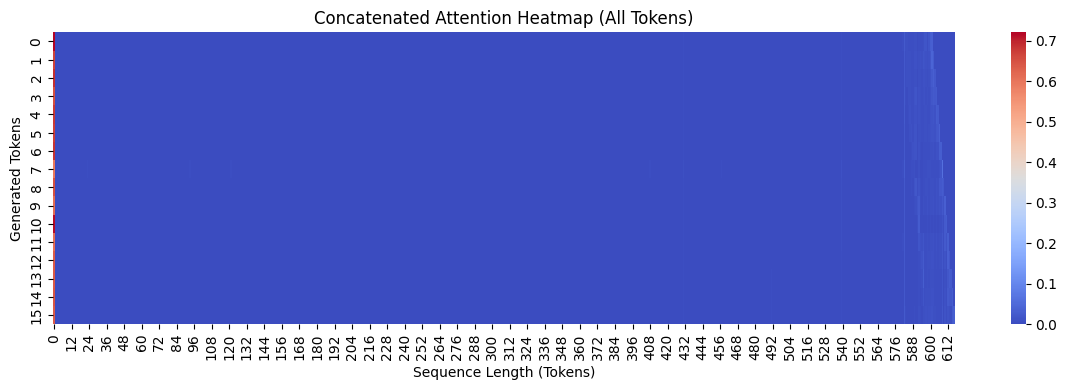

In [40]:
image_path = "./images/Getty_cat.jpg"
question = "Is there more than 100 cats in this image?"
cache, text, img_token_idx = get_attention_weights_example(question=question, image_path=image_path)
# cache, text, img_token_idx = get_attention_weights_example(model=model, question=question, image_path=image_path)
print(text)
for i in range(2, 3):
    attn_all_layers = cache['LlamaSdpaAttention.forward'][32*(i+1):32*(i+2)]
    token = processor.batch_decode(outputs["sequences"])[0][i]
    print(token, "token")
    print(attn_all_layers[0].size(), "attn layers")
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    image_attns = attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+576]
    image_attn_sum = torch.sum(image_attns)
    attn_before_image = attn_all_layers_tensor[:, :, 1:img_token_idx]
    attn_after_image = attn_all_layers_tensor[:, :, img_token_idx+576:]
    text_attn_sum = torch.sum(attn_before_image)
    text_attn_sum2 = torch.sum(attn_after_image)
    print(image_attns.size(), image_attn_sum, attn_before_image.size(), attn_after_image.size(),  text_attn_sum, text_attn_sum2)
    # fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)
# Assume that the output attentions are of the shape (generated_token_length, layers, 1, heads, 1, seq_len)
generated_token_length = int(len(cache['LlamaSdpaAttention.forward']) / 32 - 1)
max_seq_len = cache['LlamaSdpaAttention.forward'][-1].shape[-1] # Max sequence length over all generated tokens
attns_per_token = []
for i in range(generated_token_length):
    attns_per_token.append(cache['LlamaSdpaAttention.forward'][32*(i+1):32*(i+2)])
concatenated_attentions = pad_and_concat_attentions(attns_per_token, max_seq_len)
draw_concatenated_attention_heatmap(concatenated_attentions)